# Protein subcellular location prediction

In [34]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import os
import requests
from tqdm.auto import tqdm
%matplotlib inline
import random
from keras.models import Sequential, Model
from keras.layers import Dense, AveragePooling1D
from keras.layers import Dropout, Activation, Add, Input
from keras.layers import Conv1D, Flatten, Conv1D, MaxPooling1D, BatchNormalization
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.utils import plot_model
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras.regularizers import l2
from tensorflow.keras import backend as K
random.seed(666)

Import the data:

In [35]:
train = np.load('../data/reduced_train.npz')
validation = np.load('../data/reduced_val.npz')
print(f'{train}\n{validation}')
X_train = train['X_train']
Y_train = train['y_train']
mask_train = train['mask_train']
X_val = validation['X_val']
Y_val = validation['y_val']
mask_val = validation['mask_val']

NpzFile '../data/reduced_train.npz' with keys: X_train, y_train, mask_train
NpzFile '../data/reduced_val.npz' with keys: X_val, y_val, mask_val


Observe the data, the proteins sequences:

In [36]:
print(f'X_train shape : {X_train.shape}')
print(f'Y_train shape : {Y_train.shape}')
print(f'mask_train shape : {mask_train.shape}')
print(f'X_val shape : {X_val.shape}')
print(f'Y_val shape : {Y_val.shape}')
print(f'mask_val shape : {mask_val.shape}')

X_train shape : (2423, 400, 20)
Y_train shape : (2423,)
mask_train shape : (2423, 400)
X_val shape : (635, 400, 20)
Y_val shape : (635,)
mask_val shape : (635, 400)


Text(0.5, 1.0, 'Ocurrence of protein labels')

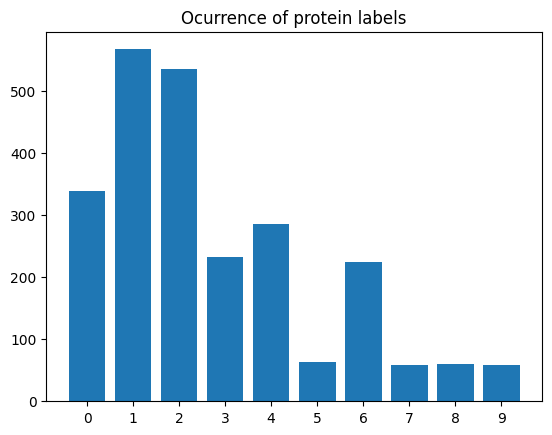

In [37]:
unique, counts = np.unique(Y_train, return_counts=True)
plt.bar(unique.astype(str), counts)
plt.title('Ocurrence of protein labels')

The classes are unbalanced, we will therefore not use the accuracy for the metric.

Prepare the data:

In [38]:
Y_train_oh = to_categorical(Y_train)
Y_val_oh = to_categorical(Y_val)

### CNN model

Define the model:

In [39]:
callback = EarlyStopping(monitor='val_accuracy',
                         patience=20,
                         restore_best_weights=True)

In [40]:
random.seed(666)
## to implement F1 score instead of accuracy (unbalanced data)
def f1_score(y_true, y_pred):
    """
    Cette fonction est faites pour aller dans la liste des metrics de Model.compile()
    Args:
        - y_true : les vraies valeurs
        - y_pred : les valeurs prédites
    
    Retourne le score f1
    """
    y_pred = K.round(y_pred)  # Round predictions to the nearest integer
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))  # True Positives
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))  # False Positives
    fn = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))  # False Negatives

    precision = tp / (tp + fp + K.epsilon())  # Precision calculation
    recall = tp / (tp + fn + K.epsilon())  # Recall calculation

    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())  # F1 Score calculation
    return f1

def make_cnn():
    model = Sequential()

    model.add(Conv1D(filters=64, kernel_size=(3), activation='relu', 
                     kernel_initializer='he_uniform'))
    # model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=(2)))
    model.add(Conv1D(filters=128, kernel_size=(3), activation='relu', 
                     kernel_initializer='he_uniform'))
    model.add(Dropout(0.3))
    model.add(MaxPooling1D(pool_size=(2)))
    model.add(Conv1D(filters=256, kernel_size=(3), activation='relu', 
                     kernel_initializer='he_uniform'))
    model.add(MaxPooling1D(pool_size=(2)))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(units=64, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dense(10, activation='softmax'))

    opt = optimizers.RMSprop(learning_rate=0.0001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy', f1_score, test_true, test_pred])

    return model

Train the model:

In [41]:
model_cnn = make_cnn()
# plot_model(model_cnn, to_file="../img/model_loc_cnn.png",
#                show_shapes=True, show_layer_names=True)

In [42]:
model_cnn = make_cnn()
# plot_model(model_cnn, to_file="../img/model_loc_cnn.png",
#                show_shapes=True, show_layer_names=True)
hist_cnn = model_cnn.fit(X_train, 
                          Y_train_oh, 
                          validation_split=0.2, 
                          epochs=20, 
                          batch_size=100)
model_cnn.save('../results/model_loc_cnn.keras')

Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.2782 - f1_score: 0.0462 - loss: 2.1421 - test_pred: 0.1000 - test_true: 0.1000 - val_accuracy: 0.3237 - val_f1_score: 0.0086 - val_loss: 2.0607 - val_test_pred: 0.1000 - val_test_true: 0.1000
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.3314 - f1_score: 0.1104 - loss: 1.9458 - test_pred: 0.1000 - test_true: 0.1000 - val_accuracy: 0.3918 - val_f1_score: 0.0363 - val_loss: 1.9754 - val_test_pred: 0.1000 - val_test_true: 0.1000
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.4005 - f1_score: 0.1572 - loss: 1.8367 - test_pred: 0.1000 - test_true: 0.1000 - val_accuracy: 0.4763 - val_f1_score: 0.0676 - val_loss: 1.9450 - val_test_pred: 0.1000 - val_test_true: 0.1000
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.4521 - f1_score: 0.1860 - loss: 1.7450 - test_pred: 0.1000 - test_true: 0.1000 - val_accuracy: 0.4536 - val_f1_score: 0.1342 - val_loss: 1.8208 - val_test_pred: 0.1

Evaluate the model:

dict_keys(['accuracy', 'f1_score', 'loss', 'test_pred', 'test_true', 'val_accuracy', 'val_f1_score', 'val_loss', 'val_test_pred', 'val_test_true'])


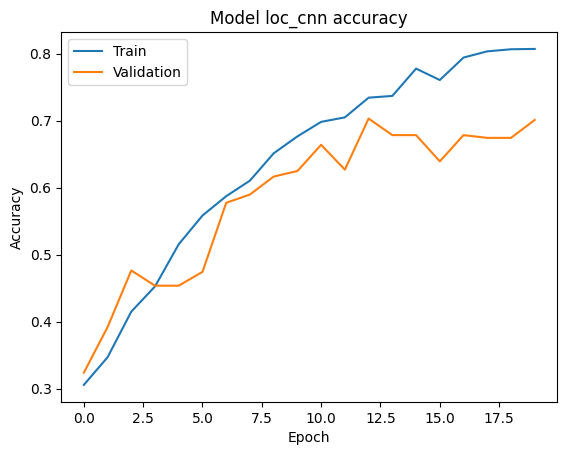

dict_keys(['accuracy', 'f1_score', 'loss', 'test_pred', 'test_true', 'val_accuracy', 'val_f1_score', 'val_loss', 'val_test_pred', 'val_test_true'])


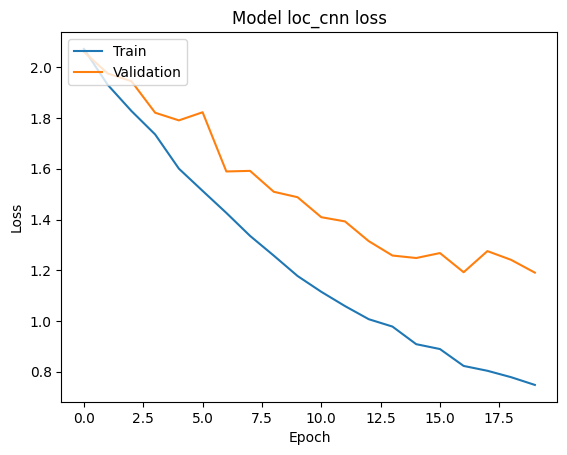

dict_keys(['accuracy', 'f1_score', 'loss', 'test_pred', 'test_true', 'val_accuracy', 'val_f1_score', 'val_loss', 'val_test_pred', 'val_test_true'])


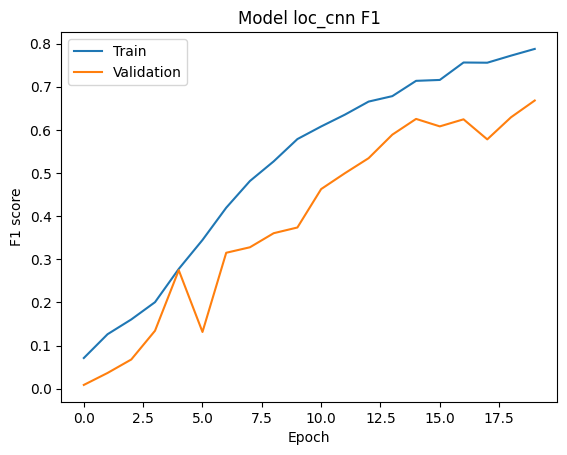

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


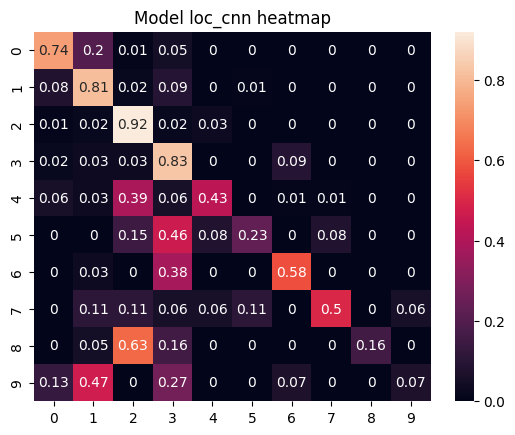

In [43]:
## plot of accuracy
print(hist_cnn.history.keys())
plt.plot(hist_cnn.history['accuracy'])
plt.plot(hist_cnn.history['val_accuracy'])
plt.title('Model loc_cnn accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
plt.savefig('../img/model_loc_cnn_accuracy')

## plot of loss
print(hist_cnn.history.keys())
plt.plot(hist_cnn.history['loss'])
plt.plot(hist_cnn.history['val_loss'])
plt.title('Model loc_cnn loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
plt.savefig('../img/model_loc_cnn_loss')

## plot of f1
print(hist_cnn.history.keys())
plt.plot(hist_cnn.history['f1_score'])
plt.plot(hist_cnn.history['val_f1_score'])
plt.title('Model loc_cnn F1')
plt.ylabel('F1 score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
plt.savefig('../img/model_loc_cnn_f1')

Y_pred_oh_cnn = model_cnn.predict(X_val)
Y_pred = np.argmax(Y_pred_oh_cnn,axis = 1)
conf_matrix = confusion_matrix(Y_val, Y_pred, normalize='true')
conf_matrix = np.around(conf_matrix, 2)
heatmap = sns.heatmap(conf_matrix, annot=True)
heatmap.set_title('Model loc_cnn heatmap')
fig = heatmap.get_figure()
fig.savefig("../img/model_loc_cnn_heatmap.png")

### RESNET

In [44]:
random.seed(666)
## to implement F1 score instead of accuracy (unbalanced data)
def f1_score(y_true, y_pred):
    """
    Cette fonction est faites pour aller dans la liste des metrics de Model.compile()
    Args:
        - y_true : les vraies valeurs
        - y_pred : les valeurs prédites
    
    Retourne le score f1
    """
    y_pred = K.round(y_pred)  # Round predictions to the nearest integer
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))  # True Positives
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))  # False Positives
    fn = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))  # False Negatives

    precision = tp / (tp + fp + K.epsilon())  # Precision calculation
    recall = tp / (tp + fn + K.epsilon())  # Recall calculation

    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())  # F1 Score calculation
    return f1

def residual_cell(input, channels):
    """
    Args:
        - input : une cellule résiduelle
        - channels : le nombre de filtres pour la convolution 1D
    
    Retourne une cellule residuelle
    """
    stride = 1
    kernel_size = 3
    x_shortcut = input 
    x = input
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv1D(channels, 1)(input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv1D(channels, kernel_size, padding='same', strides=stride, kernel_regularizer=l2(0.001))(x)
    output = Add()([x,x_shortcut])
    output = Dropout(0.2)(output)
    return(output)

def make_RNN(cell_number):
    """
    Args:
        - cell_number : le nombre de cellules résiduelle utilisées
    
    Retourne un modèle résiduel
    """
    input = Input(shape=(400, 20))
    residual_i = input
    for i in range(cell_number):
        residual_i = residual_cell(residual_i, 20)
        residual_i = MaxPooling1D(2,strides=1)(residual_i)
    residual_i = AveragePooling1D(2,strides=1)(residual_i)
    residual_i = Flatten()(residual_i)
    # residual_i = Dropout(0.3)(residual_i)
    residual_i = Dense(32, activation='relu')(residual_i)
    # residual_i = Dropout(0.3)(residual_i)
    output = Dense(10, activation='softmax')(residual_i)
    model = Model(inputs = input, outputs = output)
    opt = optimizers.Adam(learning_rate=0.00001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy', f1_score])
    return(model)

model_rnn = make_RNN(2)
# print(f'{model_rnn.summary()}')

In [45]:
hist_rnn = model_rnn.fit(X_train, 
                         Y_train_oh, 
                         validation_split=0.2, 
                         epochs=30, 
                         batch_size=100)

Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.1826 - f1_score: 0.0714 - loss: 2.7672 - val_accuracy: 0.2062 - val_f1_score: 0.0000e+00 - val_loss: 2.2986
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.2343 - f1_score: 0.0634 - loss: 2.3581 - val_accuracy: 0.2351 - val_f1_score: 0.0000e+00 - val_loss: 2.2874
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.2516 - f1_score: 0.0825 - loss: 2.2119 - val_accuracy: 0.2309 - val_f1_score: 0.0000e+00 - val_loss: 2.2736
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.2656 - f1_score: 0.0804 - loss: 2.1692 - val_accuracy: 0.2557 - val_f1_score: 0.0000e+00 - val_loss: 2.2593
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.3004 - f1_score: 0.1068 - loss: 2.0953 - val_accuracy: 0.2660 - val_f1_score: 0.0000e+00 - val_loss: 2.2432
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.3035 - f1_score: 0.1287 - loss: 2.0325 - val_accuracy: 0.2804 - val_f1

dict_keys(['accuracy', 'f1_score', 'loss', 'val_accuracy', 'val_f1_score', 'val_loss'])
dict_keys(['accuracy', 'f1_score', 'loss', 'val_accuracy', 'val_f1_score', 'val_loss'])


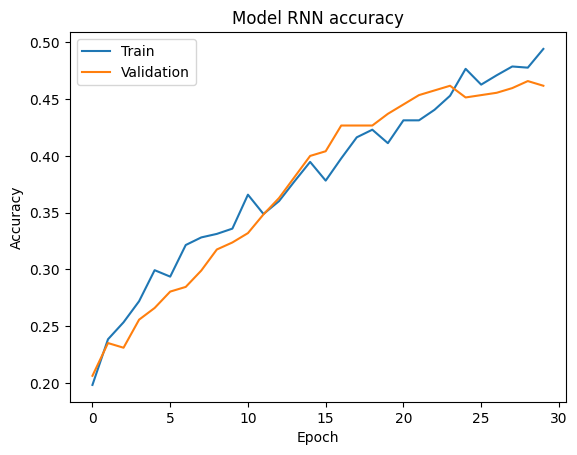

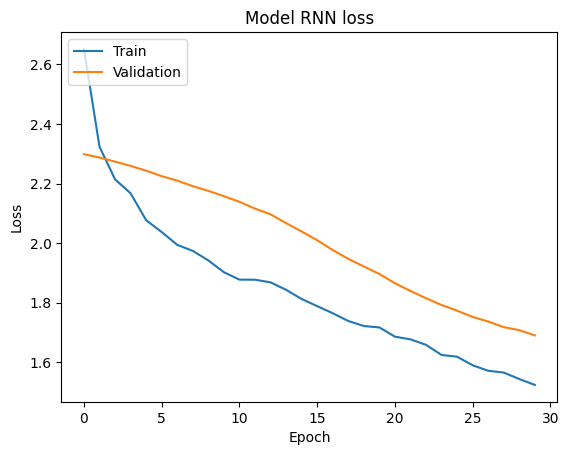

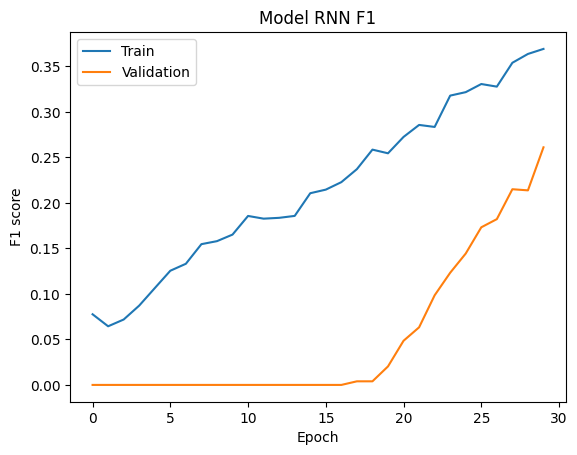

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


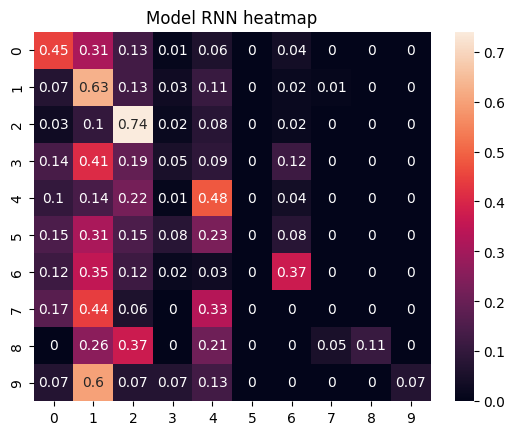

In [46]:
print(hist_rnn.history.keys())
## plot of accuracy
print(hist_rnn.history.keys())
plt.plot(hist_rnn.history['accuracy'])
plt.plot(hist_rnn.history['val_accuracy'])
plt.title('Model RNN accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
plt.savefig('../img/model_RNN_accuracy')

## plot of loss
plt.plot(hist_rnn.history['loss'])
plt.plot(hist_rnn.history['val_loss'])
plt.title('Model RNN loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
plt.savefig('../img/model_RNN_loss')

## plot of F1
plt.plot(hist_rnn.history['f1_score'])
plt.plot(hist_rnn.history['val_f1_score'])
plt.title('Model RNN F1')
plt.ylabel('F1 score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
plt.savefig('../img/model_RNN_F1')

Y_pred_oh_rnn = model_rnn.predict(X_val)
Y_pred_rnn = np.argmax(Y_pred_oh_rnn,axis = 1)
conf_matrix = confusion_matrix(Y_val, Y_pred_rnn, normalize='true')
conf_matrix = np.around(conf_matrix, 2)
heatmap = sns.heatmap(conf_matrix, annot=True)
heatmap.set_title('Model RNN heatmap')
fig = heatmap.get_figure()
fig.savefig("../img/model_RNN_heatmap.png")

Le modèle Resnet donne de moins bon résultats, en terme d'accuracy, de loss et de F1 score. Il prédit aussi moins bien les données de validations.

Le CNN parait donc meilleur dans cette situation. 